In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from scipy import stats
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pickle

In [7]:
train_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_images.pkl','rb'))
test_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_images.pkl','rb'))
TRAINING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TRAINING_LABELS.pkl','rb'))
TESTING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TESTING_LABELS.pkl','rb'))
train_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_masks.pkl','rb'))
test_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_masks.pkl','rb'))

In [ ]:
resized_train_images=np.array([ cv2.resize(i,
                                           (28,28)) for i in train_images]).reshape(2800,28,28,1)
resized_test_images=np.array([ cv2.resize(i,
                                          (28,28)) for i in test_images]).reshape(264,28,28,1)
resized_train_masks=np.array([ cv2.resize(i,
                                          (28,28)) for i in train_masks]).reshape(2800,28,28,1)
resized_test_masks=np.array([ cv2.resize(i,
                                         (28,28)) for i in test_masks]).reshape(264,28,28,1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
TRAINING_LABELS['encoded_label']=LabelEncoder().fit_transform(TRAINING_LABELS['x_train'])

In [ ]:
TESTING_LABELS['encoded_label']=LabelEncoder().fit_transform(TESTING_LABELS['x_test'])
TESTING_LABELS.head()

,x_test,glioma Tumor,meningioma Tumor,pituitary Tumor,encoded_label
0,pituitary Tumor,0.0,0.0,1.0,2
1,meningioma Tumor,0.0,1.0,0.0,1
2,meningioma Tumor,0.0,1.0,0.0,1
3,pituitary Tumor,0.0,0.0,1.0,2
4,glioma Tumor,1.0,0.0,0.0,0


In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

In [ ]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = tfp.layers.DenseVariational(ch//ratio, posterior, prior,activation='relu',
                                    kl_weight=1/train_images.shape[0],
                              kl_use_exact=True)(x)
    x = tfp.layers.DenseVariational(ch, posterior, prior, 
                                    kl_weight=1/train_images.shape[0],activation='sigmoid',
                              kl_use_exact=True)(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [4]:
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / train_images.shape[0]
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / train_images.shape[0]

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(Hidden_1,64)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(padding_2,64)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_2)
padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(padding_3,32)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_1_)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_1)
con_2_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_2)
con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)


Flat=keras.layers.Flatten()(pad_3)

Dense_1=keras.layers.Dense(512,activation='relu')(Flat)
BN_1=keras.layers.BatchNormalization()(Dense_1)
Dense_2=keras.layers.Dense(256,activation='relu')(BN_1)
BN_2=keras.layers.BatchNormalization()(Dense_2)
Dense_3=keras.layers.Dense(128,activation='relu')(BN_2)
Dense_4=keras.layers.Dense(64,activation='relu')(Dense_3)
output_1=keras.layers.Dense(1,activation='sigmoid',name='g_output')(Dense_4)
output_2=keras.layers.Dense(1,activation='sigmoid',name='m_output')(Dense_4)
output_3=keras.layers.Dense(1,activation='sigmoid',name='p_output')(Dense_4)

second_=keras.layers.Dense(128,activation='relu')(Flat)
second__=keras.layers.Dense(32,activation='relu')(second_)
combined_output=keras.layers.Dense(3,activation='softmax',name='combine_output')(second__)

Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
inferen_output=tfp.layers.OneHotCategorical(3,name='inference_out')(Dense_network)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [ ]:
BI_Based_SE_Architecture_5=keras.models.Model([Input_],[output_1,output_2,output_3,
                                                        combined_output,
                                                        inferen_output])

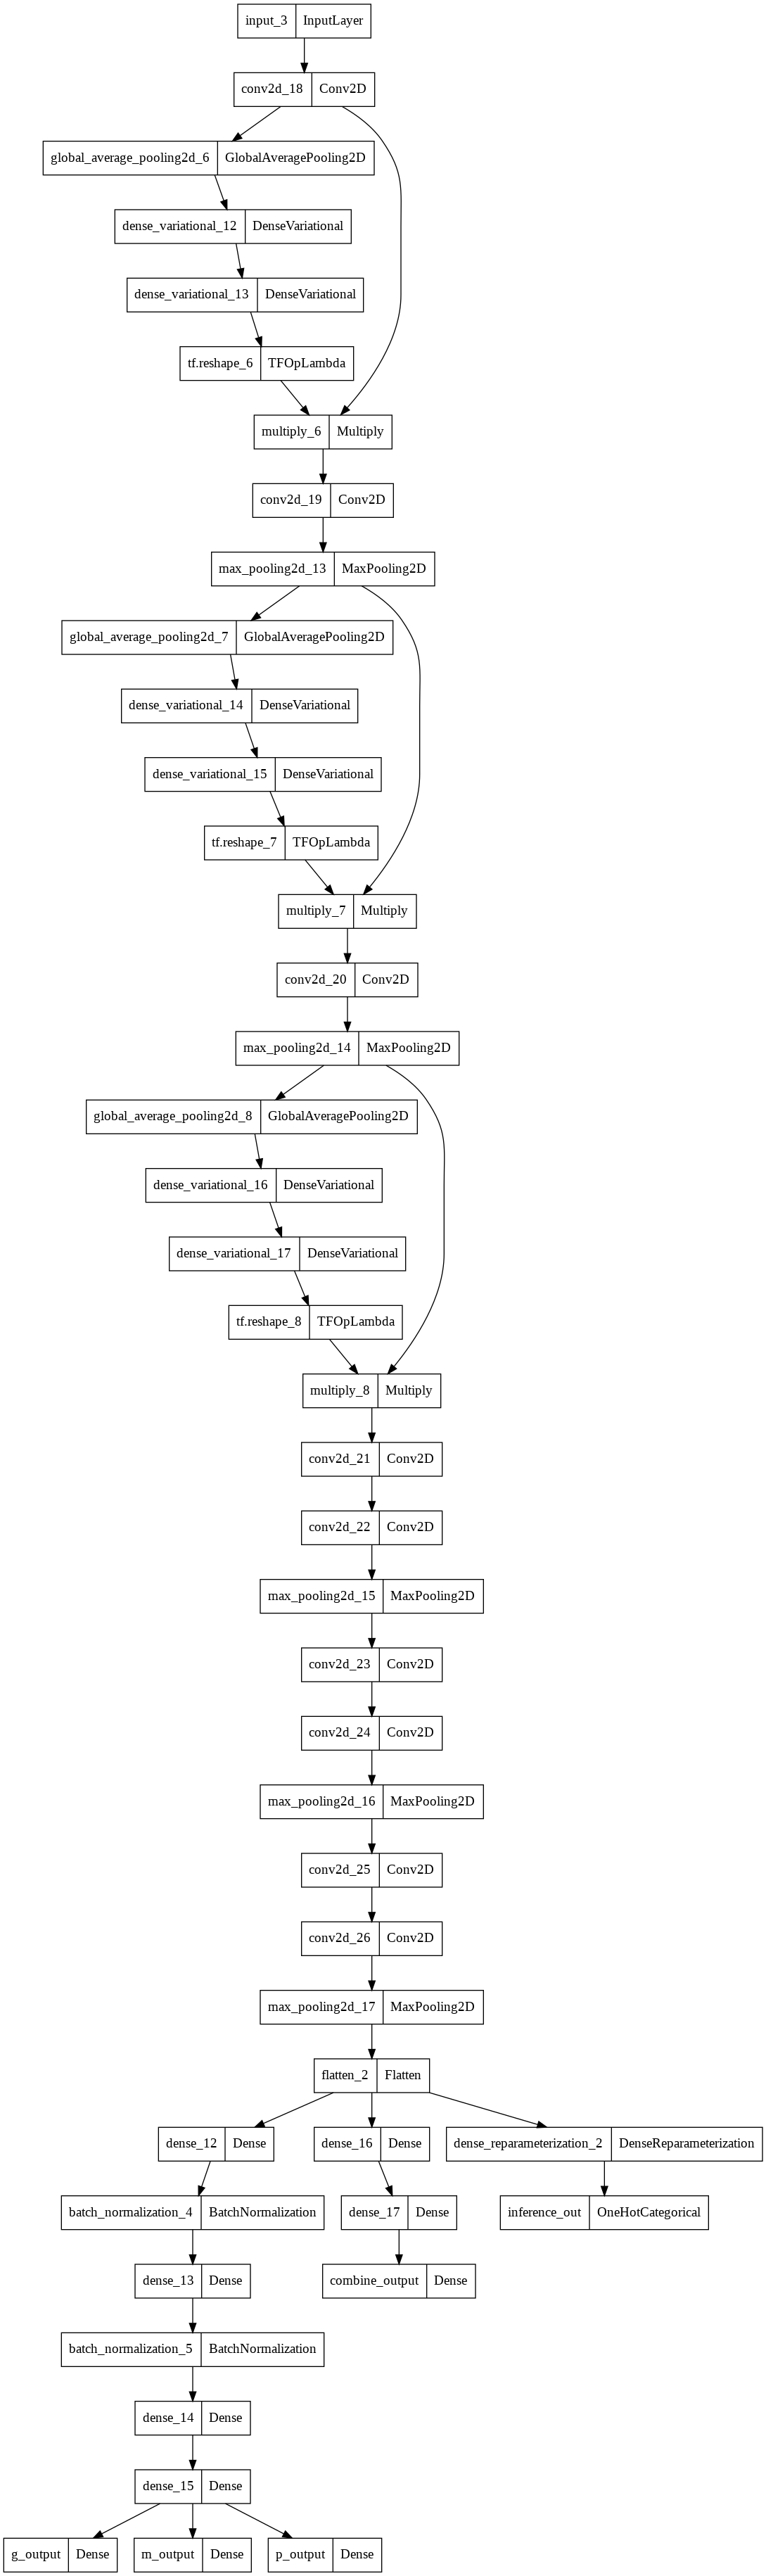

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(BI_Based_SE_Architecture_5,to_file='inferen_Model.png')

In [ ]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))
BI_Based_SE_Architecture_5.compile(loss =
                      {'g_output':'binary_crossentropy',
                       'm_output':'binary_crossentropy',
                        'p_output':'binary_crossentropy',
                       'combine_output':'sparse_categorical_crossentropy',
                               'inference_out':negative_log_likelihood
                       },
             optimizer = keras.optimizers.Adam(learning_rate=0.005),
             metrics = ['accuracy'])

In [ ]:
# os.makedirs('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/Weights')

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/Weights/best_model.hdf5",
     monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [ ]:
hist_2=BI_Based_SE_Architecture_5.fit(
                   train_images,
                   [TRAINING_LABELS['glioma Tumor'].values,
                    TRAINING_LABELS['meningioma Tumor'].values,
                    TRAINING_LABELS['pituitary Tumor'].values,
                    TRAINING_LABELS['encoded_label'].values,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
                    ]
                   ,
                   epochs=200)

Epoch 1/500
88/88 [==============================] - 12s 72ms/step - loss: 36.1252 - g_output_loss: 0.5064 - m_output_loss: 0.5085 - p_output_loss: 0.3766 - combine_output_loss: 1.0279 - inference_out_loss: 32.2955 - g_output_accuracy: 0.7425 - m_output_accuracy: 0.7561 - p_output_accuracy: 0.8300 - combine_output_accuracy: 0.5186 - inference_out_accuracy: 0.4218
Epoch 2/500
88/88 [==============================] - 7s 79ms/step - loss: 28.7466 - g_output_loss: 0.4553 - m_output_loss: 0.4448 - p_output_loss: 0.2738 - combine_output_loss: 0.8093 - inference_out_loss: 25.3939 - g_output_accuracy: 0.7768 - m_output_accuracy: 0.7786 - p_output_accuracy: 0.8886 - combine_output_accuracy: 0.6468 - inference_out_accuracy: 0.5143
Epoch 3/500
88/88 [==============================] - 6s 73ms/step - loss: 22.9138 - g_output_loss: 0.4219 - m_output_loss: 0.4373 - p_output_loss: 0.1815 - combine_output_loss: 0.6151 - inference_out_loss: 19.9188 - g_output_accuracy: 0.7893 - m_output_accuracy: 0.7800

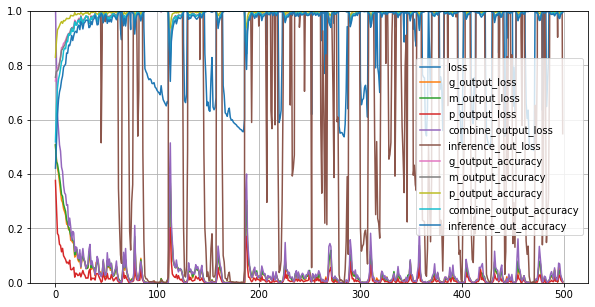

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
BI_Based_SE_Architecture_5.evaluate(
          test_images, 
         [TESTING_LABELS['glioma Tumor'].values,
       TESTING_LABELS['meningioma Tumor'].values,
      TESTING_LABELS['pituitary Tumor'].values,
      TESTING_LABELS['encoded_label'].values,
      TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
      ]
       )

9/9 [==============================] - 2s 32ms/step - loss: 26.5739 - g_output_loss: 0.2052 - m_output_loss: 0.1840 - p_output_loss: 0.0247 - combine_output_loss: 0.3378 - inference_out_loss: 25.3381 - g_output_accuracy: 0.9394 - m_output_accuracy: 0.9470 - p_output_accuracy: 0.9962 - combine_output_accuracy: 0.9242 - inference_out_accuracy: 0.9545


[26.57391357421875,
 0.20516180992126465,
 0.1840268075466156,
 0.02467598021030426,
 0.33780550956726074,
 25.338092803955078,
 0.939393937587738,
 0.9469696879386902,
 0.9962121248245239,
 0.9242424368858337,
 0.9545454382896423]

## Binary Seperable Problem Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['glioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[0])))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       151
         1.0       0.91      0.96      0.93       113

    accuracy                           0.94       264
   macro avg       0.94      0.94      0.94       264
weighted avg       0.94      0.94      0.94       264



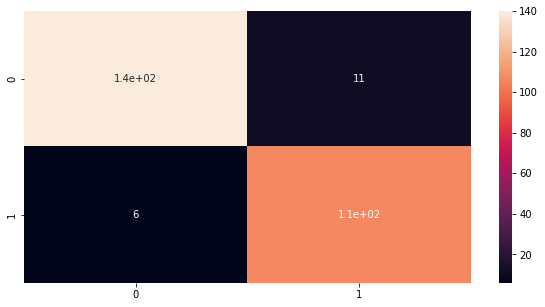

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(TESTING_LABELS['glioma Tumor'],np.round(BI_Based_SE_Architecture_5.predict(test_images)[0])),annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[1])))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       199
         1.0       0.93      0.85      0.89        65

    accuracy                           0.95       264
   macro avg       0.94      0.91      0.93       264
weighted avg       0.95      0.95      0.95       264



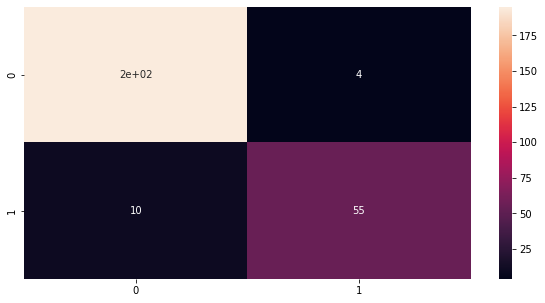

In [ ]:
sns.heatmap(confusion_matrix(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[1])),annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[2])))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       178
         1.0       1.00      0.99      0.99        86

    accuracy                           1.00       264
   macro avg       1.00      0.99      1.00       264
weighted avg       1.00      1.00      1.00       264



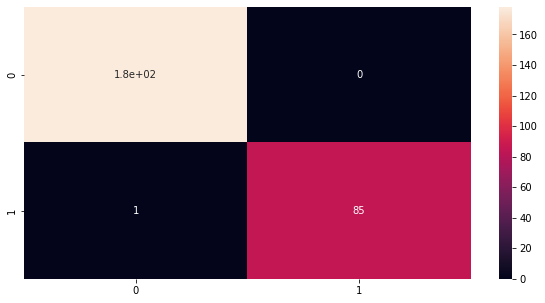

In [ ]:
sns.heatmap(confusion_matrix(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[2])),annot=True)

## Multi Class Model Repot

In [ ]:
from sklearn.metrics import classification_report
p=np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[3]))[1]
print(classification_report(TESTING_LABELS['encoded_label'].values,
      p
                 ))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       113
           1       0.93      0.82      0.87        65
           2       0.98      0.98      0.98        86

    accuracy                           0.93       264
   macro avg       0.93      0.92      0.92       264
weighted avg       0.93      0.93      0.93       264



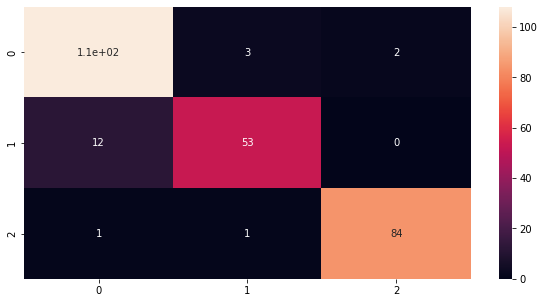

In [ ]:
sns.heatmap(confusion_matrix(TESTING_LABELS['encoded_label'].values,p),annot=True)

## Inference Based Model Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[4]))[1]
                 ))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       113
           1       0.97      0.86      0.91        65
           2       0.99      0.98      0.98        86

    accuracy                           0.95       264
   macro avg       0.95      0.94      0.94       264
weighted avg       0.95      0.95      0.95       264



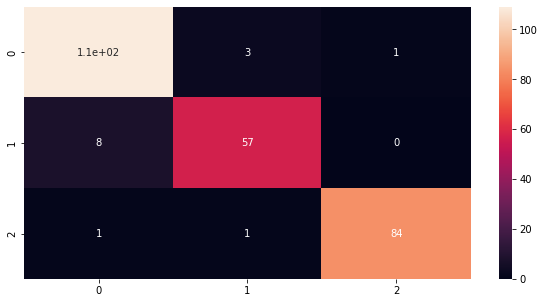

In [ ]:
sns.heatmap(confusion_matrix(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[4]))[1]),annot=True)

## Entanglement

First Model Results

In [ ]:
u=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[0:3]).reshape(264,3)))[1]
u.shape

(264,)

In [ ]:
u.shape

(263,)

Second Model Result

In [ ]:
v=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[3])))[1]
v.shape

(264,)

3rd Model Results

In [ ]:
w=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[4])))[1]
w.shape

(264,)

Entanglement

In [ ]:
u_=np.array([ i[0] for i in u.reshape(264,1)])
v_=np.array([ i[0] for i in v.reshape(264,1)])
w_=np.array([ i[0] for i in w.reshape(264,1)])

In [ ]:
Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TESTING_LABELS['encoded_label'].values})

In [ ]:
Entangled_Results.head(8)

,Model_u,Model_v,Model_w,Actual
0,1,2,2,2
1,2,1,1,1
2,0,1,1,1
3,1,2,2,2
4,2,0,0,0
5,0,0,0,0
6,1,0,0,0
7,2,0,0,2


In [ ]:
from scipy import stats
Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])

In [ ]:
Entangled_Results['entangled_preds']=Entangled_Predictions

In [ ]:
Entangled_Results.head(20)

,Model_u,Model_v,Model_w,Actual,entangled_preds
0,1,2,2,2,2
1,2,1,1,1,1
2,0,1,1,1,1
3,1,2,2,2,2
4,2,0,0,0,0
5,0,0,0,0,0
6,1,0,0,0,0
7,2,0,0,2,0
8,1,0,0,0,0
9,1,2,2,2,2


In [ ]:
print(classification_report(TESTING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       113
           1       0.98      0.83      0.90        65
           2       1.00      0.99      0.99        86

    accuracy                           0.95       264
   macro avg       0.96      0.94      0.95       264
weighted avg       0.95      0.95      0.95       264



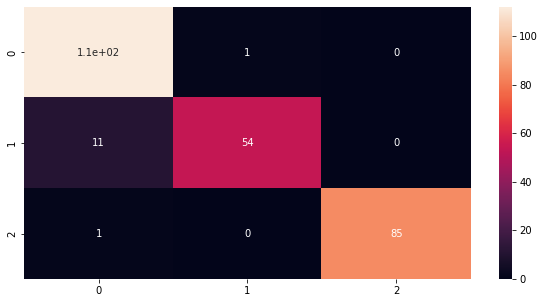

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(Entangled_Results['Actual'],Entangled_Results['entangled_preds']),annot=True)

Training Accuracy

In [ ]:
def ENTNGLED_MODEL_TRAIN(BI_Based_SE_Architecture_):
  u=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(train_images)[0:3]).reshape(2800,3)))[1]
  v=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(train_images)[3])))[1]
  w=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(train_images)[4])))[1]
  u_=np.array([ i[0] for i in u.reshape(2800,1)])
  v_=np.array([ i[0] for i in v.reshape(2800,1)])
  w_=np.array([ i[0] for i in w.reshape(2800,1)])
  Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TRAINING_LABELS['encoded_label'].values})
  Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])
  Entangled_Results['entangled_preds']=Entangled_Predictions
  print(classification_report(TRAINING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))


In [ ]:
ENTNGLED_MODEL_TRAIN(BI_Based_SE_Architecture_5)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1313
           1       1.00      1.00      1.00       643
           2       1.00      1.00      1.00       844

    accuracy                           1.00      2800
   macro avg       1.00      1.00      1.00      2800
weighted avg       1.00      1.00      1.00      2800



In [ ]:
def ENTNGLED_MODEL(BI_Based_SE_Architecture_):
  u=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[0:3]).reshape(264,3)))[1]
  v=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[3])))[1]
  w=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[4])))[1]
  u_=np.array([ i[0] for i in u.reshape(264,1)])
  v_=np.array([ i[0] for i in v.reshape(264,1)])
  w_=np.array([ i[0] for i in w.reshape(264,1)])
  Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TESTING_LABELS['encoded_label'].values})
  Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])
  Entangled_Results['entangled_preds']=Entangled_Predictions
  print(classification_report(TESTING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))
  return Entangled_Results


## Architecture with Small Size 

In [2]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [8]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(Hidden_1)
Attension_1=SE_BLOCK(Hidden_1,64)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(con_1)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu')(pad_1)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(con_2)

Flat=keras.layers.Flatten()(pad_2)

Dense_1=keras.layers.Dense(128,activation='relu')(Flat)
Dense_2=keras.layers.Dense(64,activation='relu')(Dense_1)
output_1=keras.layers.Dense(1,activation='sigmoid',name='g_output')(Dense_2)
output_2=keras.layers.Dense(1,activation='sigmoid',name='m_output')(Dense_2)
output_3=keras.layers.Dense(1,activation='sigmoid',name='p_output')(Dense_2)

second_=keras.layers.Dense(258,activation='relu')(Flat)
second__=keras.layers.Dense(64,activation='relu')(second_)
combined_output=keras.layers.Dense(3,activation='softmax',name='combine_output')(second__)

Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
inferen_output=tfp.layers.OneHotCategorical(3,name='inference_out')(Dense_network)

In [9]:
BI_Based_SE_Architecture_5_small=keras.models.Model([Input_],[output_1,output_2,output_3,
                                                        combined_output,
                                                        inferen_output])

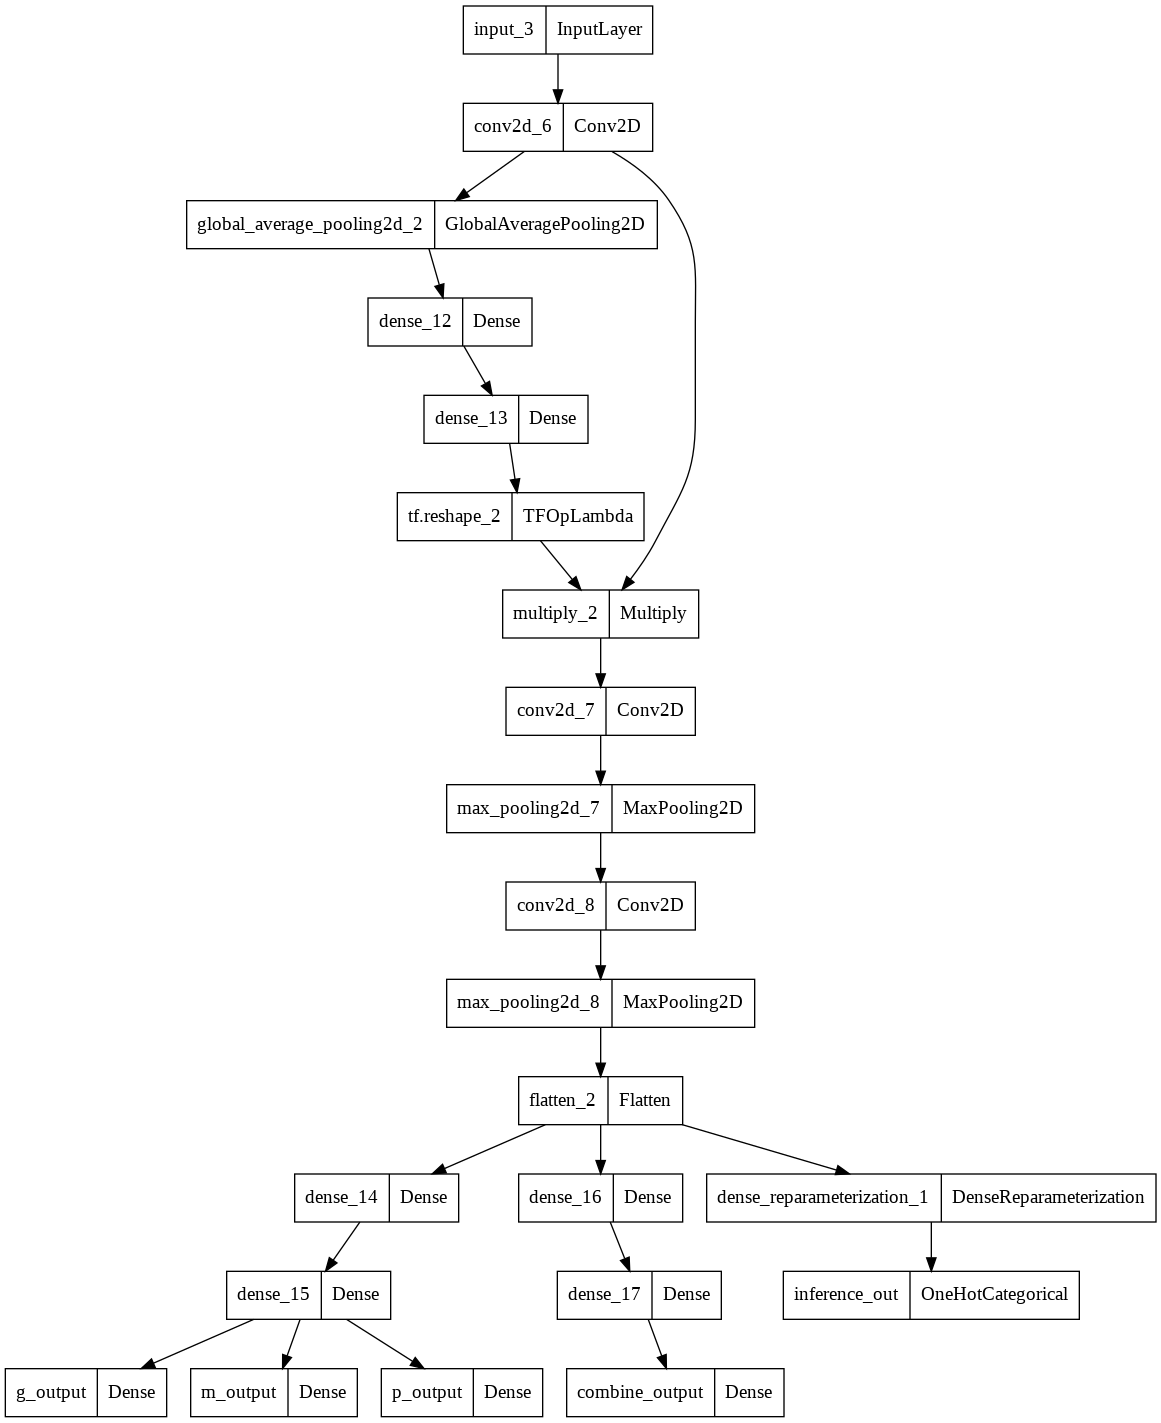

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(BI_Based_SE_Architecture_5_small)

In [ ]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))
BI_Based_SE_Architecture_5_small.compile(loss =
                      {'g_output':'binary_crossentropy',
                       'm_output':'binary_crossentropy',
                        'p_output':'binary_crossentropy',
                       'combine_output':'sparse_categorical_crossentropy',
                               'inference_out':negative_log_likelihood
                       },
             optimizer = keras.optimizers.Adam(learning_rate=0.001),
             metrics = ['accuracy'])

In [ ]:
hist_2=BI_Based_SE_Architecture_5_small.fit(
                   train_images,
                   [TRAINING_LABELS['glioma Tumor'].values,
                    TRAINING_LABELS['meningioma Tumor'].values,
                    TRAINING_LABELS['pituitary Tumor'].values,
                    TRAINING_LABELS['encoded_label'].values,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
                    ]
                     ,
                   epochs=300)

Epoch 1/300
88/88 [==============================] - 7s 56ms/step - loss: 113.5007 - g_output_loss: 0.5479 - m_output_loss: 0.4866 - p_output_loss: 0.3245 - combine_output_loss: 0.7332 - inference_out_loss: 28.3143 - g_output_accuracy: 0.7207 - m_output_accuracy: 0.7611 - p_output_accuracy: 0.8671 - combine_output_accuracy: 0.6861 - inference_out_accuracy: 0.5461
Epoch 2/300
88/88 [==============================] - 4s 50ms/step - loss: 99.2861 - g_output_loss: 0.3459 - m_output_loss: 0.3764 - p_output_loss: 0.1392 - combine_output_loss: 0.4288 - inference_out_loss: 15.4291 - g_output_accuracy: 0.8289 - m_output_accuracy: 0.8300 - p_output_accuracy: 0.9532 - combine_output_accuracy: 0.8061 - inference_out_accuracy: 0.7064
Epoch 3/300
88/88 [==============================] - 4s 51ms/step - loss: 93.6732 - g_output_loss: 0.2090 - m_output_loss: 0.2386 - p_output_loss: 0.0816 - combine_output_loss: 0.2432 - inference_out_loss: 10.8726 - g_output_accuracy: 0.9057 - m_output_accuracy: 0.8925

In [ ]:
BI_Based_SE_Architecture_5_small.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 64)          0           ['conv2d_3[0][0]']               
 obalAveragePooling2D)                                                                      

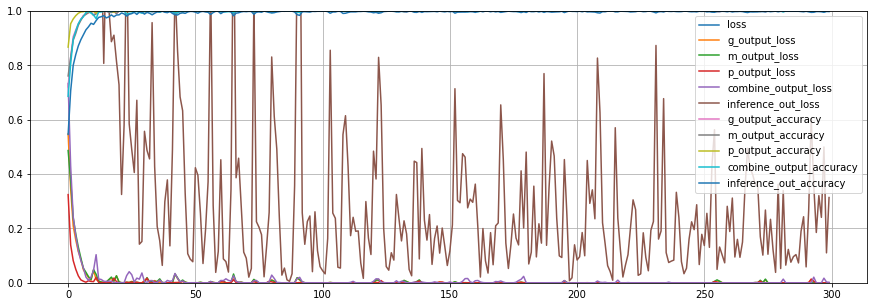

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
hist_2.history.keys()

dict_keys(['loss', 'g_output_loss', 'm_output_loss', 'p_output_loss', 'combine_output_loss', 'inference_out_loss', 'g_output_accuracy', 'm_output_accuracy', 'p_output_accuracy', 'combine_output_accuracy', 'inference_out_accuracy'])

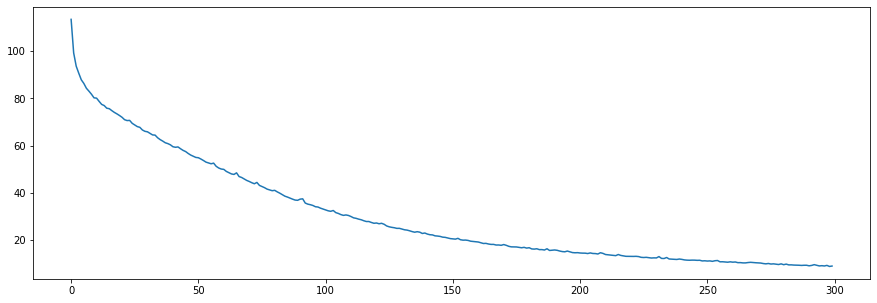

In [ ]:
plt.plot(hist_2.history['loss'])

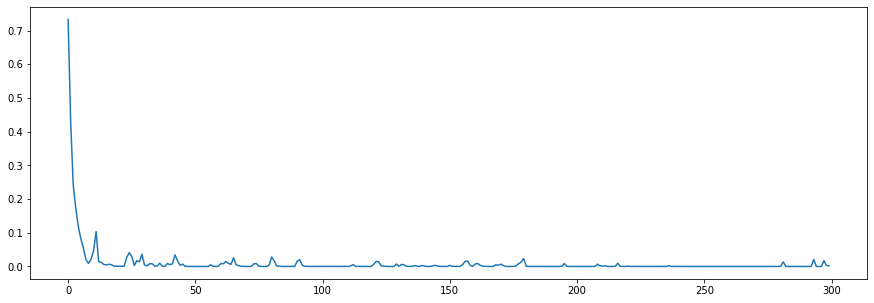

In [ ]:
plt.plot(hist_2.history['combine_output_loss'])

In [ ]:
plt.plot(hist_2.history['g_output_loss'])

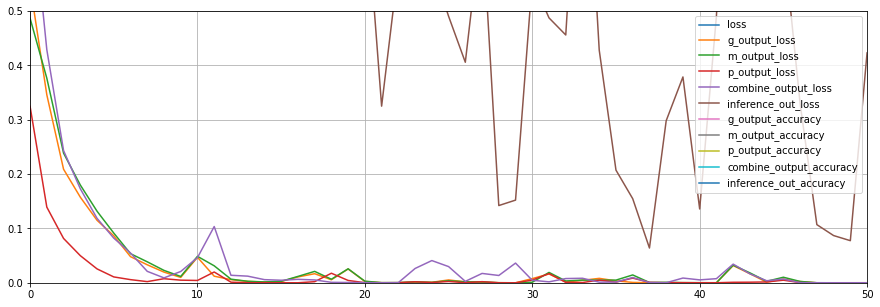

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_xlim(0,50)
plt.gca().set_ylim(0,0.5)
plt.show()

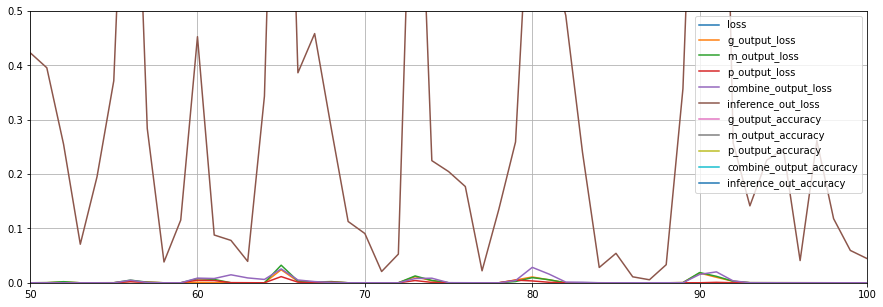

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_xlim(50,100)
plt.gca().set_ylim(0,0.5)
plt.show()

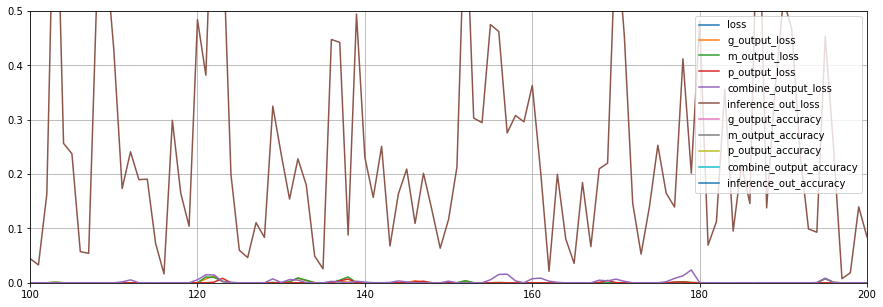

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_xlim(100,200)
plt.gca().set_ylim(0,0.5)
plt.show()

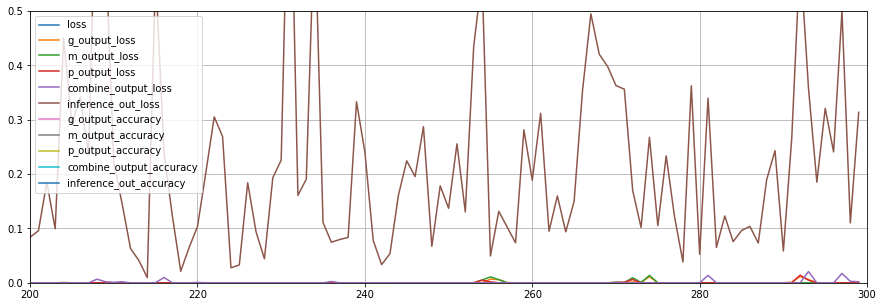

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_xlim(200,300)
plt.gca().set_ylim(0,0.5)
plt.show()

In [ ]:
BI_Based_SE_Architecture_5_small.evaluate(
          test_images, 
         [TESTING_LABELS['glioma Tumor'].values,
       TESTING_LABELS['meningioma Tumor'].values,
      TESTING_LABELS['pituitary Tumor'].values,
      TESTING_LABELS['encoded_label'].values,
      TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
      ]
       )

9/9 [==============================] - 1s 23ms/step - loss: 11.6127 - g_output_loss: 0.2562 - m_output_loss: 0.2592 - p_output_loss: 5.6357e-05 - combine_output_loss: 0.0888 - inference_out_loss: 4.8163 - g_output_accuracy: 0.9659 - m_output_accuracy: 0.9621 - p_output_accuracy: 1.0000 - combine_output_accuracy: 0.9848 - inference_out_accuracy: 0.9470


[11.612709045410156,
 0.2562139630317688,
 0.25915417075157166,
 5.6357257562922314e-05,
 0.08884226530790329,
 4.8162760734558105,
 0.9659090638160706,
 0.9621211886405945,
 1.0,
 0.9848484992980957,
 0.9469696879386902]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['glioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[0])))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       151
         1.0       0.93      0.99      0.96       113

    accuracy                           0.97       264
   macro avg       0.96      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[1])))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       199
         1.0       0.98      0.86      0.92        65

    accuracy                           0.96       264
   macro avg       0.97      0.93      0.95       264
weighted avg       0.96      0.96      0.96       264



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[2])))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       178
         1.0       1.00      1.00      1.00        86

    accuracy                           1.00       264
   macro avg       1.00      1.00      1.00       264
weighted avg       1.00      1.00      1.00       264



## Multi Output

In [ ]:
from sklearn.metrics import classification_report
p=np.where(np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[3]))[1]
print(classification_report(TESTING_LABELS['encoded_label'].values,
      p
                 ))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       113
           1       0.96      0.98      0.97        65
           2       1.00      1.00      1.00        86

    accuracy                           0.98       264
   macro avg       0.98      0.99      0.98       264
weighted avg       0.99      0.98      0.98       264



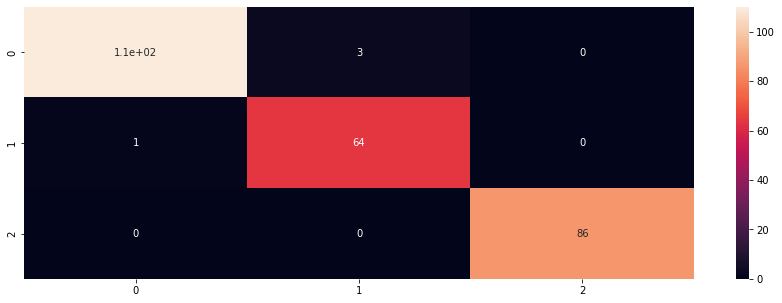

In [ ]:
sns.heatmap(confusion_matrix(TESTING_LABELS['encoded_label'].values,p),annot=True)

## Inference Model

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[4]))[1]
                 ))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.94      0.92      0.93        65
           2       0.99      0.99      0.99        86

    accuracy                           0.96       264
   macro avg       0.96      0.96      0.96       264
weighted avg       0.96      0.96      0.96       264



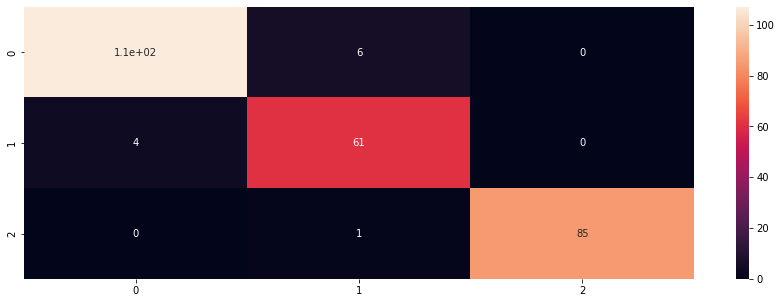

In [ ]:
sns.heatmap(confusion_matrix(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[4]))[1]),annot=True)

In [ ]:
def ENTNGLED_MODEL_TRAIN(BI_Based_SE_Architecture_):
  u=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(train_images)[0:3]).reshape(2800,3)))[1]
  v=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(train_images)[3])))[1]
  w=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(train_images)[4])))[1]
  u_=np.array([ i[0] for i in u.reshape(2800,1)])
  v_=np.array([ i[0] for i in v.reshape(2800,1)])
  w_=np.array([ i[0] for i in w.reshape(2800,1)])
  Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TRAINING_LABELS['encoded_label'].values})
  Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])
  Entangled_Results['entangled_preds']=Entangled_Predictions
  print(classification_report(TRAINING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))
  return Entangled_Results
ret=ENTNGLED_MODEL_TRAIN(BI_Based_SE_Architecture_5_small)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1313
           1       1.00      1.00      1.00       643
           2       1.00      1.00      1.00       844

    accuracy                           1.00      2800
   macro avg       1.00      1.00      1.00      2800
weighted avg       1.00      1.00      1.00      2800



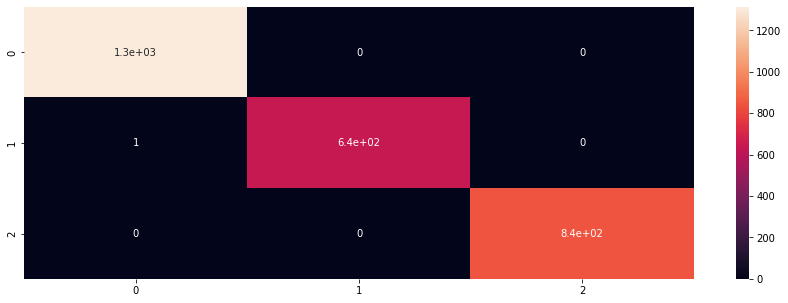

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(ret['Actual'],ret['entangled_preds']),annot=True)

In [ ]:
u=np.where(np.round(np.array(BI_Based_SE_Architecture_5_small.predict(test_images)[0:3]).reshape(264,3)))[1]
v=np.where(np.round(np.array(BI_Based_SE_Architecture_5_small.predict(test_images)[3])))[1]
w=np.where(np.round(np.array(BI_Based_SE_Architecture_5_small.predict(test_images)[4])))[1]
u_=np.array([ i[0] for i in u.reshape(263,1)])
v_=np.array([ i[0] for i in v[:263].reshape(263,1)])
w_=np.array([ i[0] for i in w[:263].reshape(263,1)])
Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TESTING_LABELS['encoded_label'].values[:263]})
Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])
Entangled_Results['entangled_preds']=Entangled_Predictions
print(classification_report(TESTING_LABELS['encoded_label'].values[:263],Entangled_Results['entangled_preds']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       113
           1       0.98      0.97      0.98        65
           2       1.00      0.99      0.99        85

    accuracy                           0.99       263
   macro avg       0.99      0.99      0.99       263
weighted avg       0.99      0.99      0.99       263



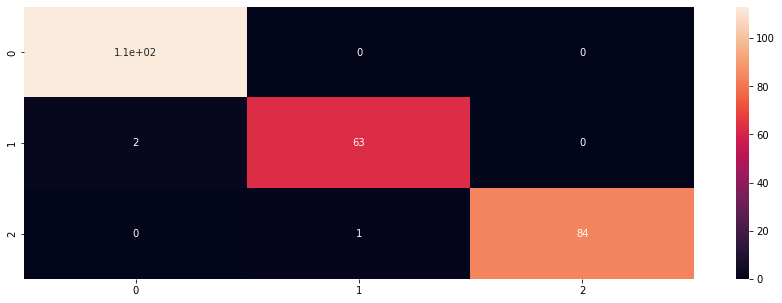

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(Entangled_Results['Actual'],Entangled_Results['entangled_preds']),annot=True)